<div style="height: 4px; background-color: white; margin-top: 20px; margin-bottom: 20px;"></div>

# Time Series Forecasting on energy consumption 

In [1]:
#import the necesary libraries and the csv file that we are gonna need
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_palet=sns.color_palette()

df=pd.read_csv('/home/alvaro/Documents/JupyterLab1/AEP_hourly.csv')
df.head()


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [2]:
#set de Datetime as index
df= df.set_index('Datetime')
#Convert the index to datetime format
df.index= pd.to_datetime(df.index)


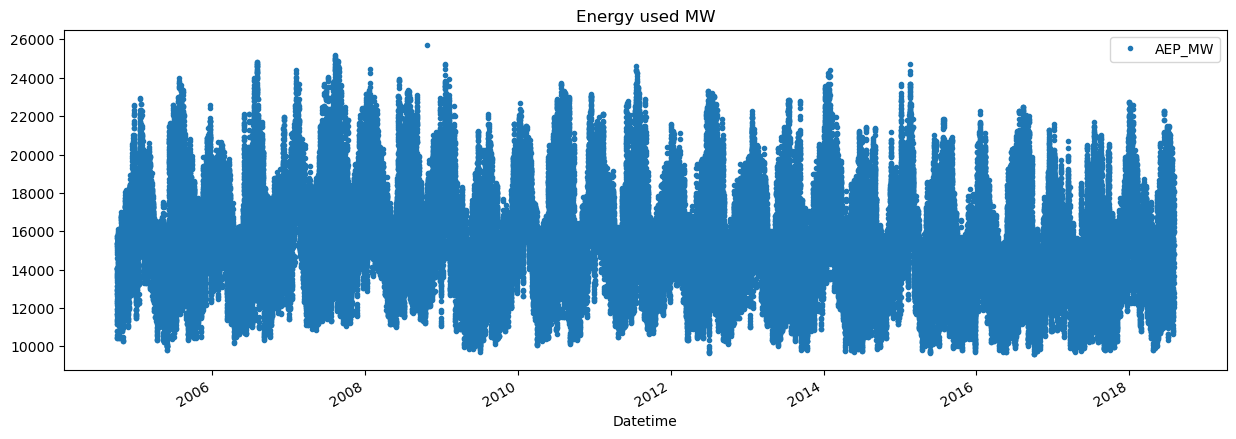

In [3]:
#plot the data
df.plot(style='.', figsize=(15,5), color=color_palet[0], title='Energy used MW')
plt.show()

# The data looks pretty uniform (No outliers)


<div style="height: 4px; background-color: black; margin-top: 20px; margin-bottom: 20px;"></div>

# Train/Test split with TimeSeriesSplit (sklearn) 

`TimeSeriesSplit` from `sklearn` is a cross-validation technique specifically designed for time series data. It sequentially splits the dataset into training and testing sets, respecting the temporal order of observations. This ensures that the training set always contains observations that occurred prior to those in the testing set, mimicking how you would forecast future values in real-world scenarios.



- The this method provides the following pros:
1) Multiple Evaluations: Provides a more thorough evaluation by testing the model on multiple time periods.
2) Prevents Data Leakage: Ensures that future data is not used in training, which is crucial in time series forecasting.
3) Flexibility: Parameters like n_splits, test_size, and gap offer flexibility in how the data is split.

- Also the following cons:
1) Computational Cost: More computationally intensive due to multiple training phases.
2) Variable Train/Test Sizes: The size of each train/test set can vary, which might affect model performance and evaluation consistency.


- By applying this code you would be able to plot how the Train/Test Split works, latter on we will aplly it w/out plotting it

```python
# Initialize TimeSeriesSplit with 5 splits, a test size of one year (24 hours * 365 days),
# and a gap of 24 hours between the training and test set.
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 365, gap=24)

# It's important to sort the DataFrame by the index (usually time) to ensure that the
# TimeSeriesSplit works correctly, respecting the temporal order.
df = df.sort_index()

# Create a subplot environment with 5 rows and 1 column, sharing the x-axis (time).
fix, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
# Loop over each split produced by TimeSeriesSplit.
for train_index, test_index in tss.split(df):
    # Extract the training and test sets based on the indices provided by TimeSeriesSplit.
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    # Plot the training set in the current subplot.
    train['AEP_MW'].plot(ax=axs[fold], label='Train Set', title=f'Data Train/Test split fold:{fold}')
    # Plot the test set in the same subplot.
    test['AEP_MW'].plot(ax=axs[fold], label='Test Set')
    # Add a vertical line to indicate the split point between the training and test set.
    axs[fold].axvline(test.index.min(), color='black', ls='--')

    # Move to the next subplot for the next iteration.
    fold += 1

# Display the plot.
plt.show()



# Another way to make a Train/Test split is by a fixed split

 - Pros
 1) Simplicity: Easy to understand and implement.
 2) Stability: The split is consistent, allowing for stable model evaluation over time.
 - Cons:
 1) Potential Overfitting: If the data has temporal trends, the model may overfit to the specific characteristics of the training period.
 2) No Cross-Validation: Lacks the ability to validate the model across different time periods, which can be crucial for time series data.
 3) Fixed Proportion: It doesn't allow for flexibility in changing the proportion of training and testing data.

```python
# approximately 80/20 split
train = df.loc[df.index < '01-01-2015']  # 80%
test = df.loc[df.index >= '01-01-2015']  # 20%

# show the data split
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# How 1 week of data looks like:
df.loc[(df.index > '01-01-2011') & (df.index < '01-08-2011')].plot(figsize=(15, 5), title='Week of data')
plt.show()


<div style="height: 4px; background-color: black; margin-top: 20px; margin-bottom: 20px;"></div>


# Forecast Horizons

+ It's the length of time into the future for which the model generates forecasts, starting from the end of the available data. The choice of horizon impacts the modeling approach and the accuracy of predictions, as longer horizons typically increase the uncertainty and potential error of forecasts.

### 📅 Understanding Forecast Horizons in Time Series

- **The Essence of Time**: In the world of your AEP hourly data, a forecast horizon represents how far into the future we want to predict energy usage. It's the window through which we gaze to anticipate what's coming. Whether it's the next 24 hours or a week ahead, each horizon tells a different part of the story.
- **Harmonizing with TimeSeriesSplit**: `TimeSeriesSplit` isn't just about dividing data; it's about respecting the flow of time in our predictions. With each split, we're not only training our model but also setting the stage for various forecast horizons, aligning our training with real-time, sequential prediction needs.

### 📅 The Chronological Split: Training vs. Testing 📊
- Imagine a timeline of your data. To train our model, we take a slice of this timeline (the past) and teach our model all about it. 📚
- But here's the twist: we don't just guess the immediate future. We test our model's skills on data points that lie just beyond our forecast horizon. This is how we ensure our time-traveling model really knows its stuff! 🚀

### 🔄 Rolling Horizons vs. 📌 Fixed Horizons: Choose Your Adventure
- **Rolling Horizons**: Think of it like a conveyor belt of predictions, constantly moving forward. Always forecasting a set period into the future, perfect for when you need continuous updates. 🔄
- **Fixed Horizons**: These are your goalposts. We're aiming for a specific point in time, useful for project planning and hitting those key dates. 🎯

### 🤹 Challenges of Long-term Forecasts
- Forecasting is part art, part science. When we look way ahead, things get tricky. Why? Well, our world loves to change!
- Seasonal shifts, economic rollercoasters, and all sorts of trends make long-term forecasts a juggling act. 🌍🤹
- But fear not! By feeding our model external data and using sophisticated techniques, we can tackle these challenges head-on, refining our gaze into the future. 🧠💡


<div style="height: 4px; background-color: black; margin-top: 20px; margin-bottom: 20px;"></div>

# Feature Creation
+ Time series features

In [4]:
#create a function that takes the data frame and return the data frame with the features added

def featureCreaton(df):
    """
    Creates timeseries feature based on timeseries index
    """
    df=df.copy()
    df['hour']= df.index.hour
    df['dayofweek']= df.index.dayofweek
    df['quarter']= df.index.quarter
    df['month']= df.index.month
    df['year']= df.index.year
    df['dayofyear']= df.index.dayofyear
    df['dayofmonth']=df.index.day
    df['weekofyear']=df.index.isocalendar().week
    return df


#call the function, btw I realized a misstype on the function's name but later I found it funny
df=featureCreaton(df)
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,53
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,53
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,53


<div style="height: 4px; background-color: black; margin-top: 20px; margin-bottom: 20px;"></div>

# Lag Features

In forecasting models for energy consumption, lag features represent the past values of energy usage which are used as inputs to predict future usage. These features are crucial for capturing patterns and dependencies over time, essentially providing the model with a memory of how energy consumption has changed in previous hours or days. For instance, the energy usage from yesterday or the last week at the same hour can be used as lag features. This approach is vital in models like linear regression or machine learning algorithms, which may not inherently understand time series data, enabling them to recognize and leverage temporal patterns in energy consumption for more accurate predictions.


### 🧩 Integrating Lag Features for Depth and Context

- **Backward Glances for Forward Leaps**: Lag features in this context are more than just historical data points; they provide the depth and context needed for accurate predictions across different horizons.
- **Crafting the Lags**: By selecting appropriate lags, we equip our model with the temporal insights necessary to navigate through the chosen forecast horizon, enhancing its predictive prowess.

In [5]:
#Out target value is df['AEP_MW'], so we are gonna create a dict to map this lag features into our df
target_map= df['AEP_MW'].to_dict()

In [6]:
#we use 364 because 364%7 =0 so we can acces the exact day of the week and don't have to worry about mapping out days of the week
def addLags(df):
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('726 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [7]:
df= addLags(df)
df.head()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2004-12-31 01:00:00,13478.0,1,4,4,12,2004,366,31,53,NaN,NaN,NaN
2004-12-31 02:00:00,12865.0,2,4,4,12,2004,366,31,53,NaN,NaN,NaN
2004-12-31 03:00:00,12577.0,3,4,4,12,2004,366,31,53,NaN,NaN,NaN
2004-12-31 04:00:00,12517.0,4,4,4,12,2004,366,31,53,NaN,NaN,NaN
2004-12-31 05:00:00,12670.0,5,4,4,12,2004,366,31,53,NaN,NaN,NaN


+ As we can see the lags are empty because we are looking at the furthest day back in history that we have data on, and there is no wat to compute those lags for that far hack in the history, but if we look at the tail of those lags...

In [8]:
df.tail()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-01-01 20:00:00,21089.0,20,0,1,1,2018,1,1,1,14832.0,18011.0,20189.0
2018-01-01 21:00:00,20999.0,21,0,1,1,2018,1,1,1,14621.0,17978.0,19953.0
2018-01-01 22:00:00,20820.0,22,0,1,1,2018,1,1,1,14153.0,17396.0,19329.0
2018-01-01 23:00:00,20415.0,23,0,1,1,2018,1,1,1,13500.0,16763.0,18736.0
2018-01-02 00:00:00,19993.0,0,1,1,1,2018,2,2,1,12841.0,16123.0,17962.0


# Train using cross validation

In [9]:
# Initialize TimeSeriesSplit with 5 splits, a test size of one year (24 hours * 365 days),
# and a gap of 24 hours between the training and test set.
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 365, gap=24)

# It's important to sort the DataFrame by the index (usually time) to ensure that the
# TimeSeriesSplit works correctly, respecting the temporal order.
df = df.sort_index()

# Initialize variables to store predictions and scores for each split.
preds=[]
scores=[]
# Loop over each split produced by TimeSeriesSplit.
for train_index, test_index in tss.split(df):
    # Extract the training and test sets based on the indices provided by TimeSeriesSplit.
    train = df.iloc[train_index]
    test = df.iloc[test_index]

    # Apply feature creation to both training and test sets
    train=featureCreaton(train)
    test=featureCreaton(test)

    # Define the features and target variable for the model.
    FEATURES=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3']
    TARGET='AEP_MW'

    # Prepare training and testing data.
    X_train= train[FEATURES]
    y_train= train[TARGET]
    
    X_test= test[FEATURES]
    y_test= test[TARGET]

    
    #set the params here to easy tunning later
    p1=5 #max_depth should be between 3-10 Decreasing this hyperparameter reduces the likelihood of overfitting
    p2=0.001 #learning rate
    p3='gbtree' #booster This param could be 'gbtree': normal gradient booster decision tree |‘gblinear’: uses a linear model instead of decision trees| ‘dart’: adds dropout to the standard gradient boosting algorithm
    p4=0 #n_jobs Number of parallel threads. When set to zero, then the optimal number of threads will be inferred automatically
    p5=1000 #n_estimators Decreasing this hyperparameter reduces the likelihood of overfitting [10,inf]
    p6=50 #early_stopping_rounds
    p7='reg:linear' #objective

    # Initialize the XGBRegressor and set its parameters.
    reg= xgb.XGBRegressor()
    args = {'max_depth': p1, 'learning_rate': p2, 'booster': p3, 'n_jobs': p4,
            'n_estimators': p5, 'early_stopping_rounds': p6, 'objective': p7}
    reg.set_params(**args)
    # Fit the model to the training data and evaluate it on both training and testing sets.
    reg.fit(X_train, y_train,
            eval_set= [(X_train, y_train), (X_test, y_test)],
            verbose= 100)
    # Predict on the test set and store the predictions on preds variable.
    y_pred= reg.predict(X_test)
    preds.append(y_pred)
    # Calculate the RMSE for the current split and store the score on the scores variable.
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)


[0]	validation_0-rmse:2566.63461	validation_1-rmse:2686.57126


/home/alvaro/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:50:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2425.44556	validation_1-rmse:2531.82157
[200]	validation_0-rmse:2301.35590	validation_1-rmse:2395.20282
[300]	validation_0-rmse:2192.73861	validation_1-rmse:2275.35884
[400]	validation_0-rmse:2098.23902	validation_1-rmse:2171.53695
[500]	validation_0-rmse:2015.58941	validation_1-rmse:2082.37163
[600]	validation_0-rmse:1943.21169	validation_1-rmse:2005.28225
[700]	validation_0-rmse:1879.99790	validation_1-rmse:1937.73345
[800]	validation_0-rmse:1824.80133	validation_1-rmse:1879.03273
[900]	validation_0-rmse:1776.35401	validation_1-rmse:1828.25424
[999]	validation_0-rmse:1734.03228	validation_1-rmse:1785.93277
[0]	validation_0-rmse:2577.99219	validation_1-rmse:2631.45636


/home/alvaro/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:50:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2434.59569	validation_1-rmse:2475.31713
[200]	validation_0-rmse:2309.05339	validation_1-rmse:2338.21123
[300]	validation_0-rmse:2198.86446	validation_1-rmse:2218.87117
[400]	validation_0-rmse:2102.80210	validation_1-rmse:2115.21157
[500]	validation_0-rmse:2019.06254	validation_1-rmse:2025.04194
[600]	validation_0-rmse:1946.02270	validation_1-rmse:1947.11802
[700]	validation_0-rmse:1882.44225	validation_1-rmse:1878.59400
[800]	validation_0-rmse:1826.79376	validation_1-rmse:1818.58003
[900]	validation_0-rmse:1778.19663	validation_1-rmse:1768.45535
[999]	validation_0-rmse:1736.20101	validation_1-rmse:1724.69033
[0]	validation_0-rmse:2582.41917	validation_1-rmse:2737.57558


/home/alvaro/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:50:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2437.62936	validation_1-rmse:2581.62829
[200]	validation_0-rmse:2311.30850	validation_1-rmse:2445.10249
[300]	validation_0-rmse:2200.56477	validation_1-rmse:2325.45585
[400]	validation_0-rmse:2103.51899	validation_1-rmse:2221.87795
[500]	validation_0-rmse:2018.20554	validation_1-rmse:2133.00120
[600]	validation_0-rmse:1944.37858	validation_1-rmse:2057.66802
[700]	validation_0-rmse:1880.05592	validation_1-rmse:1993.18558
[800]	validation_0-rmse:1823.92501	validation_1-rmse:1937.48920
[900]	validation_0-rmse:1775.12010	validation_1-rmse:1890.33301
[999]	validation_0-rmse:1732.93425	validation_1-rmse:1850.34826
[0]	validation_0-rmse:2593.69762	validation_1-rmse:2645.70408


/home/alvaro/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:50:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2447.95356	validation_1-rmse:2492.88415
[200]	validation_0-rmse:2320.78191	validation_1-rmse:2361.57467
[300]	validation_0-rmse:2209.57443	validation_1-rmse:2247.89175
[400]	validation_0-rmse:2112.51757	validation_1-rmse:2151.44905
[500]	validation_0-rmse:2028.14640	validation_1-rmse:2069.98464
[600]	validation_0-rmse:1954.84316	validation_1-rmse:2002.38224
[700]	validation_0-rmse:1890.63743	validation_1-rmse:1947.92208
[800]	validation_0-rmse:1835.07946	validation_1-rmse:1903.41937
[900]	validation_0-rmse:1786.50382	validation_1-rmse:1867.43887
[999]	validation_0-rmse:1744.50526	validation_1-rmse:1837.36139
[0]	validation_0-rmse:2596.66378	validation_1-rmse:2504.72553


/home/alvaro/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2451.74257	validation_1-rmse:2356.81356
[200]	validation_0-rmse:2325.44430	validation_1-rmse:2229.66407
[300]	validation_0-rmse:2215.19241	validation_1-rmse:2121.02488
[400]	validation_0-rmse:2119.06130	validation_1-rmse:2024.83234
[500]	validation_0-rmse:2035.62878	validation_1-rmse:1944.80412
[600]	validation_0-rmse:1963.13916	validation_1-rmse:1880.55003
[700]	validation_0-rmse:1900.20223	validation_1-rmse:1826.27293
[800]	validation_0-rmse:1845.74632	validation_1-rmse:1780.14490
[900]	validation_0-rmse:1797.80165	validation_1-rmse:1742.09763
[999]	validation_0-rmse:1756.38871	validation_1-rmse:1712.24454


In [10]:
print(f'Scores across folds (mean) {np.mean(scores):0.4f}')
print(f'Fold Scores {scores}')


Scores across folds (mean) 1782.1155
Fold Scores [1785.9327732979084, 1724.6903293410194, 1850.3482566244786, 1837.3613899694976, 1712.2445367062267]


# Feature Importance within the model


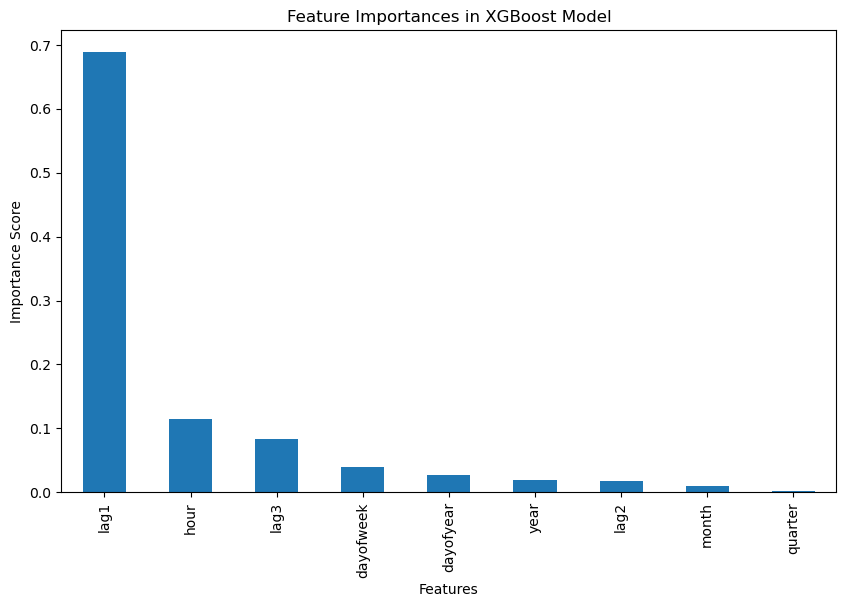

In [11]:

# Extract feature importances from the model
feature_importances = reg.feature_importances_

# Create a pandas Series for easy plotting
importances_series = pd.Series(feature_importances, index=FEATURES)

# Sort the feature importances for better visualization
sorted_importances = importances_series.sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='bar')
plt.title('Feature Importances in XGBoost Model')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.show()


# Predictign the Future

### 1. Maximizing Insights from Historical Data 📚
- **Comprehensive Model Training**: Post cross-validation, we utilize the entire dataset for training. This approach ensures that our model is well-versed with the nuances and patterns present in the historical data, providing a robust foundation for accurate future predictions.

### 2. Generating Predictive Time Frames 📅
- **Future Time Stamps Creation**: In this step, we generate future time stamps that align with the frequency of our historical data. This methodical approach is critical for maintaining consistency in our predictive models and sets the stage for accurate forecasting.

### 3. Feature Engineering for future predictions 🎨
- **Strategic Feature Engineering**: We extend our feature engineering to the future time stamps, mirroring the process used for historical data. This includes the generation of lag features and other time-dependent variables, ensuring that our model has all the necessary inputs to make informed predictions.

### 4. Utilizing XGBoostRegressor for forecasting  🔮
- **Employing XGBoostRegressor for Prediction**: With our model finely tuned and our future dataset prepared, we deploy `XGBoostRegressor` to predict future values. This powerful, gradient-boosting framework is particularly adept at handling complex patterns in time series data.

### 5. Refining model outputs 💎
- **Post-Prediction Processing**: After generating predictions, we engage in post-processing steps to refine the output. This may include adjustments for scale, alignment with business logic, or other domain-specific modifications, ensuring our forecasts are practical and actionable.

### 6. Analyzing predictive insights  🌐 (not covered here)
- **Forecast Interpretation and Application**: The final and crucial step involves interpreting the model's forecasts. In domains like energy consumption, these insights can drive strategic planning, operational efficiency, and informed decision-making, translating data-driven predictions into real-world impact.


In [12]:
#retrain on all data again
df=featureCreaton(df)

FEATURES=['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'lag1', 'lag2', 'lag3']
TARGET='AEP_MW'

X_all= df[FEATURES]
y_all= df[TARGET]

#set the params here to easy tunning later
p1=5 #max_depth should be between 3-10 Decreasing this hyperparameter reduces the likelihood of overfitting
p2=0.001 #learning rate
p3='gbtree' #booster This param could be 'gbtree': normal gradient booster decision tree |‘gblinear’: uses a linear model instead of decision trees| ‘dart’: adds dropout to the standard gradient boosting algorithm
p4=0 #n_jobs Number of parallel threads. When set to zero, then the optimal number of threads will be inferred automatically
p5=1000 #n_estimators Decreasing this hyperparameter reduces the likelihood of overfitting [10,inf]
p6=50 #early_stopping_rounds
p7='reg:linear' #objective

# Initialize the XGBRegressor and set its parameters.
reg= xgb.XGBRegressor()
args = {'max_depth': p1, 'learning_rate': p2, 'booster': p3, 'n_jobs': p4,
        'n_estimators': p5, 'early_stopping_rounds': p6, 'objective': p7}
reg.set_params(**args)
# Fit the model to the training data and evaluate it on both training and testing sets.
reg.fit(X_train, y_train,
        eval_set= [(X_train, y_train), (X_test, y_test)],
        verbose= 100)

[0]	validation_0-rmse:2596.66378	validation_1-rmse:2504.72553


/home/alvaro/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [07:51:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:2451.74257	validation_1-rmse:2356.81356
[200]	validation_0-rmse:2325.44430	validation_1-rmse:2229.66407
[300]	validation_0-rmse:2215.19241	validation_1-rmse:2121.02488
[400]	validation_0-rmse:2119.06130	validation_1-rmse:2024.83234
[500]	validation_0-rmse:2035.62878	validation_1-rmse:1944.80412
[600]	validation_0-rmse:1963.13916	validation_1-rmse:1880.55003
[700]	validation_0-rmse:1900.20223	validation_1-rmse:1826.27293
[800]	validation_0-rmse:1845.74632	validation_1-rmse:1780.14490
[900]	validation_0-rmse:1797.80165	validation_1-rmse:1742.09763
[999]	validation_0-rmse:1756.38871	validation_1-rmse:1712.24454


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=0,
             num_parallel_tree=None, objective='reg:linear', ...)

In [13]:
#Looking for the max value on out data frame to make it the first value on our future data frame
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [14]:
# Generate a DataFrame for future dates ranging hourly from 2018-08-03 to 2019-08-01.
future= pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df= pd.DataFrame(index=future)

# Add a flag to differentiate between historical (False) and future (True) data points.
future_df['isFuture'] = True
df['isFuture'] = False


# Combine historical data and future data into a single DataFrame.
df_and_future= pd.concat([df, future_df])

# Apply feature creation and lag features to the combined DataFrame.
df_and_future = featureCreaton(df_and_future)
df_and_future = addLags(df_and_future)

In [15]:
# Extract and create a separate DataFrame for future data points with all the engineered features.
future_w_feaures= df_and_future.query('isFuture').copy()

In [16]:
future_w_feaures

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,8,2018,215,3,31,15045.0,14425.0,13669.0,True
2018-08-03 01:00:00,NaN,1,4,3,8,2018,215,3,31,13940.0,13383.0,12772.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,215,3,31,13230.0,12564.0,12253.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,215,3,31,12624.0,11985.0,11928.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,215,3,31,12410.0,11697.0,11696.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,16579.0,15625.0,20026.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,16457.0,15087.0,19529.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,16197.0,14657.0,19029.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,15259.0,13866.0,17790.0,True


# Now we predict the futureab

In [17]:
future_w_feaures['pred'] = reg.predict(future_w_feaures[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

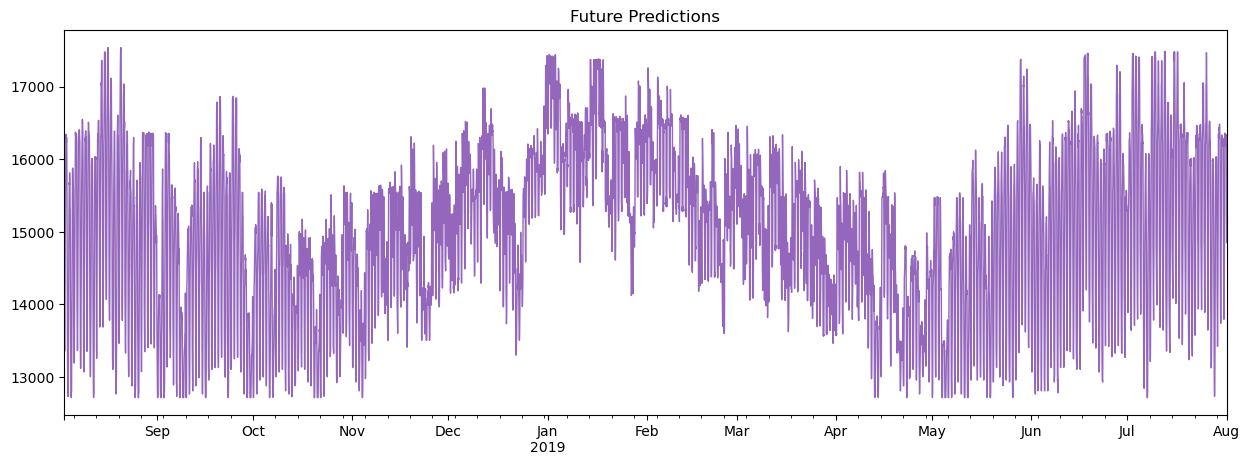

In [18]:
#Now we plot 
future_w_feaures['pred'].plot(figsize=(15,5),
                             color= color_palet[4],
                             ms=1,
                             lw=1,
                             title='Future Predictions')

# Now we save the model for later

In [19]:
#save the model
reg.save_model('model.json')

In [20]:
#Load the model
reg.load_model('model.json')